In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps
sns.set_theme()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_ml = pd.read_csv('data_ml.csv')

# 1 Data Inspection

In [3]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7030 entries, 0 to 7029
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7030 non-null   int64  
 1   gender            7030 non-null   object 
 2   SeniorCitizen     7030 non-null   object 
 3   Partner           7030 non-null   object 
 4   Dependents        7030 non-null   object 
 5   tenure            7030 non-null   int64  
 6   PhoneService      7030 non-null   object 
 7   MultipleLines     7030 non-null   object 
 8   InternetService   7030 non-null   object 
 9   OnlineSecurity    7030 non-null   object 
 10  OnlineBackup      7030 non-null   object 
 11  DeviceProtection  7030 non-null   object 
 12  TechSupport       7030 non-null   object 
 13  StreamingTV       7030 non-null   object 
 14  StreamingMovies   7030 non-null   object 
 15  Contract          7030 non-null   object 
 16  PaperlessBilling  7030 non-null   object 


In [4]:
#Checking levels of categorical features
for i in data_ml.columns:
    if data_ml[i].dtype == 'object':
        print(f'{i} {data_ml[i].unique()}')

gender ['Female' 'Male']
SeniorCitizen ['No' 'Yes']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


# 2 Feature Engineering

The dataset was partially processed during the exploratory data analysis (Part 1): Datatypes were changed. Redundant variables were deletet, outliers were and missing values were transformed (-> see Part 1: Exploratory Data Analysis)

## 2.1 Delete redundant variable

In [5]:
#Delete first column
data_ml = data_ml.iloc[:,1:]

In [6]:
#data_ml = data_ml[['gender','Partner','Dependents','SeniorCitizen','MultipleLines','PaperlessBilling','PaymentMethod','PhoneService','Contract','InternetService','MonthlyCharges','TotalCharges','Churn','tenure']]

## 2.2 Binning

Binning of feature 'tenure' due to the multimodal nature of the data. Goal was to keep the original distribution.
The distribution of tenure must be frequently monitored 

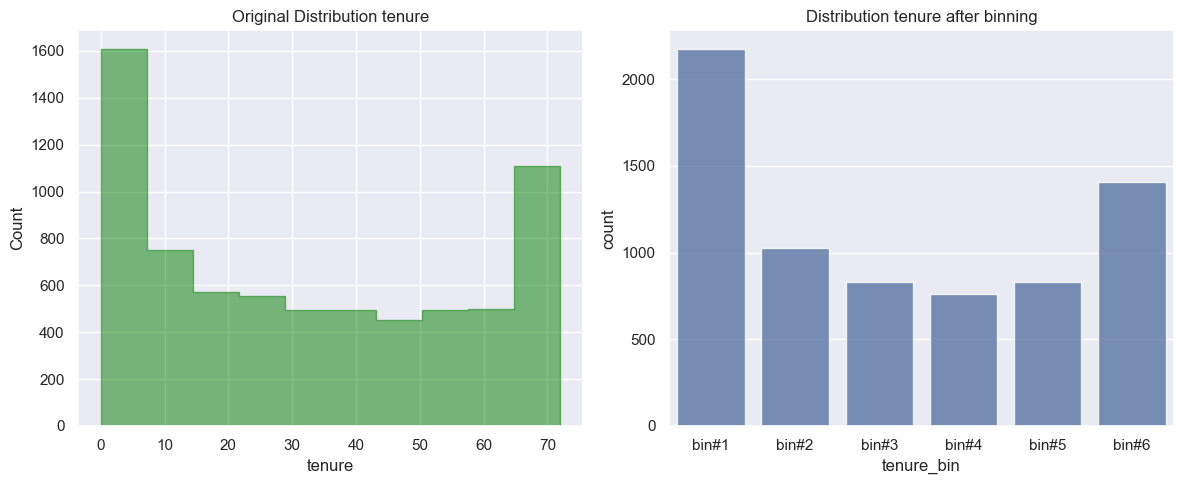

In [7]:
#Binning feature tenure in 6 parts
data_ml['tenure_bin'] = pd.cut(x=data_ml.tenure, bins=6, labels=['bin#1','bin#2','bin#3','bin#4','bin#5','bin#6'])

#Plot tenure and tenure after binning
fig,ax = plt.subplots(1,2,figsize=(12,5))

#Subplot 1: tenure
ax[0].hist(data_ml.tenure,histtype='step',fill=True,color='green',alpha=0.5)
ax[0].set_title('Original Distribution tenure')
ax[0].set_xlabel('tenure')
ax[0].set_ylabel('Count')

#Subplot 2: tenure after binning
sns.countplot(x=data_ml.tenure_bin,order=['bin#1','bin#2','bin#3','bin#4','bin#5','bin#6'],ax=ax[1],alpha=0.8)
ax[1].set_title('Distribution tenure after binning')

plt.tight_layout()

In [8]:
#Droping original feature tenure
data_ml = data_ml.drop(columns='tenure')

In [9]:
#Seperate data into categorical features and numerical features 
data_cat = data_ml.select_dtypes(include=['object','category']).copy()
data_num = data_ml.select_dtypes(include=['float64','int64']).copy()

## 2.3 One Hot Encoding

In [10]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

#instantiate and fit One Hot Encoder with categorical features
ohe = OneHotEncoder(drop='first', sparse_output=False)
data_cat_encoded = ohe.fit_transform(data_cat)

#Generate Dataframe with encoded categorical features
feature_names = ohe.get_feature_names_out(input_features=data_cat.columns)
data_cat_df = pd.DataFrame(data_cat_encoded, columns=feature_names, index=data_cat.index)

#Concat encoded categorical features with numerical features
data_trans = pd.concat([data_cat_df, data_num], axis=1)

## 2.4 Train Test Split

In [11]:
from sklearn.model_selection import train_test_split

#Train/Test Split
X = data_trans.drop(columns='Churn_Yes')
y = data_trans['Churn_Yes']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123,stratify=y)

In [12]:
#Change datatypes back into 'objects'
X_train.loc[:, ~X_train.columns.isin(['MonthlyCharges', 'TotalCharges'])] = X_train.loc[:, ~X_train.columns.isin(['MonthlyCharges', 'TotalCharges'])].astype('object')

In [13]:
#Check count columns after one hot encoding
X_train.shape

(5624, 34)

## 2.5 Scaling: Quantile Transforming

Quantile transformation of the features 'MonthlyCharges' and 'Total Charges'
.fit_transform of X_train and .transform of X_test to avoid data leakage

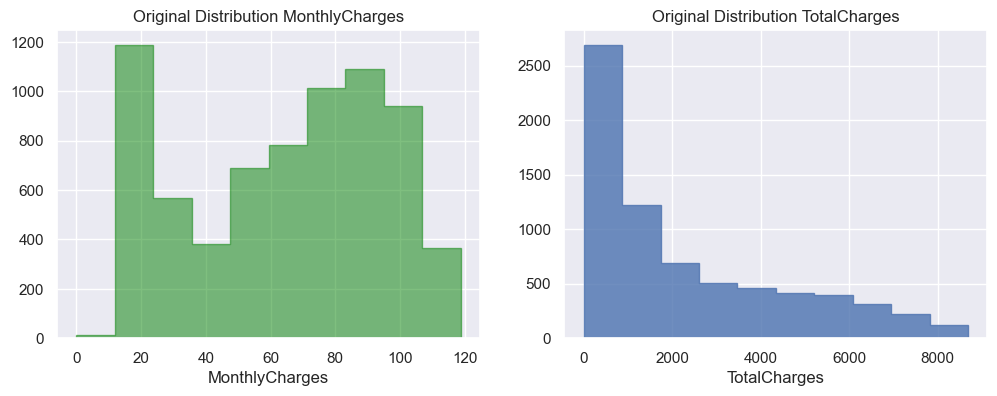

In [14]:
#Plot original distribution of Monthly and Total Charges

fig, ax = plt.subplots(1,2,figsize=(12,4))

#Subplot 1: Monthlycharges
data_ml.MonthlyCharges.hist(ax=ax[0],histtype='step',fill=True,color='green',alpha=0.5)
ax[0].set_title('Original Distribution MonthlyCharges')
ax[0].set_xlabel('MonthlyCharges')
ax[0].set_ylabel=('Count')

#Subplot 1: Totalcharges
data_ml.TotalCharges.hist(ax=ax[1],histtype='step',fill=True,alpha=0.8)
ax[1].set_title('Original Distribution TotalCharges')
ax[1].set_xlabel('TotalCharges')
ax[1].set_ylabel=('Count')

In [15]:
#Quantil Transforming
from sklearn.preprocessing import QuantileTransformer

#Instantiate Quantile Transformer
quantile_normal = QuantileTransformer(output_distribution='normal')

# Fit Transform X_train
X_train[['MonthlyCharges','TotalCharges']] = quantile_normal.fit_transform(X_train[['MonthlyCharges','TotalCharges']])

#Transform X_test
X_test[['MonthlyCharges','TotalCharges']] = quantile_normal.transform(X_test[['MonthlyCharges','TotalCharges']])

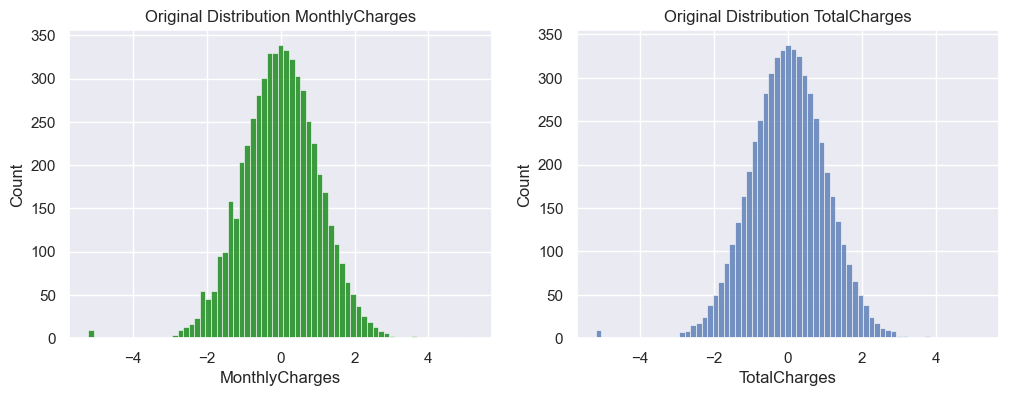

In [16]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

#Subplot 1: transformed MonthlyCharges
sns.histplot(X_train.MonthlyCharges,ax=ax[0],color='green')
ax[0].set_title('Original Distribution MonthlyCharges')
ax[0].set_xlabel('MonthlyCharges')
ax[0].set_ylabel=('Count')

#Subplot 1: transformed TotalCharges
sns.histplot(X_train.TotalCharges,ax=ax[1])
ax[1].set_title('Original Distribution TotalCharges')
ax[1].set_xlabel('TotalCharges')
ax[1].set_ylabel=('Count')


## 2.6 Class Balancing

In [17]:
'''
#Original Distribution target 'Churn'
data_ml.Churn.value_counts(normalize=True)
'''

"\n#Original Distribution target 'Churn'\ndata_ml.Churn.value_counts(normalize=True)\n"

In [18]:
'''

#SMOTE Balancing
from imblearn.over_sampling import SMOTE

#Balancing of target 'Churn'
X_train_bal, y_train_bal = SMOTE().fit_resample(X_train,y_train)

'''


"\n\n#SMOTE Balancing\nfrom imblearn.over_sampling import SMOTE\n\n#Balancing of target 'Churn'\nX_train_bal, y_train_bal = SMOTE().fit_resample(X_train,y_train)\n\n"

## 2.7 Feature Selection

In [19]:
'''
from sklearn.feature_selection import mutual_info_classif

#Copy Train Test Split
X_train_select, X_test_select, y_train_select, y_test_select = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

#Mutual Info Classifier
mutual_info = mutual_info_classif(X_train_select,y_train_select,discrete_features='auto',random_state=123)

# Dataframe
mutual_info_df = pd.DataFrame({'Features':X_train.columns,'Mutual_Info':mutual_info})

#10 largest features
mutual_info_df.nlargest(20,columns='Mutual_Info').sort_values(by='Mutual_Info',ascending=False)

'''

"\nfrom sklearn.feature_selection import mutual_info_classif\n\n#Copy Train Test Split\nX_train_select, X_test_select, y_train_select, y_test_select = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()\n\n#Mutual Info Classifier\nmutual_info = mutual_info_classif(X_train_select,y_train_select,discrete_features='auto',random_state=123)\n\n# Dataframe\nmutual_info_df = pd.DataFrame({'Features':X_train.columns,'Mutual_Info':mutual_info})\n\n#10 largest features\nmutual_info_df.nlargest(20,columns='Mutual_Info').sort_values(by='Mutual_Info',ascending=False)\n\n"

# 3 Prediction Models

In [20]:
#Load GridSearchSV and metrics
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

## 3.1 Model 1: Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

#Instantiate LogisticRegression
lr = LogisticRegression(solver='saga')

#Dictionary for hyperparameter tuning
lr_param_dict = {'penalty':['l1','l2'],'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

#Instantiate GridsearchCV
gridcv_lr = GridSearchCV(estimator=lr,cv=5,param_grid=lr_param_dict,verbose=0)

#Fit Gridsearch with training data
gridcv_lr.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='saga'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

In [22]:
#Evaluation best params
print(f'best params: {gridcv_lr.best_params_} \n')

#Best score
print(f'best score: {gridcv_lr.best_score_} \n')

#Mean test score
print(f'mean test score: \n {gridcv_lr.cv_results_['mean_test_score']}')

best params: {'C': 100, 'penalty': 'l2'} 

best score: 0.8058366152629498 

mean test score: 
 [0.73595302 0.7361308  0.78734108 0.79907679 0.80565805 0.80494694
 0.80548059 0.80565884 0.80565884 0.80565868 0.80565884 0.80583662
 0.80583662 0.80583662]


In [23]:
#Predict y with test data
y_pred_lr = gridcv_lr.predict(X_test)

#Create empty dict
metrics_lr = {}

#Metrics to dict
metrics_lr['Accuracy'] = metrics.accuracy_score(y_test,y_pred_lr)
metrics_lr['Recall'] =metrics.recall_score(y_test,y_pred_lr)
metrics_lr['Precision'] =metrics.precision_score(y_test,y_pred_lr)
metrics_lr['F1'] = metrics.f1_score(y_test,y_pred_lr)

metrics_lr

{'Accuracy': 0.8029871977240398,
 'Recall': 0.5121293800539084,
 'Precision': 0.6643356643356644,
 'F1': 0.578386605783866}

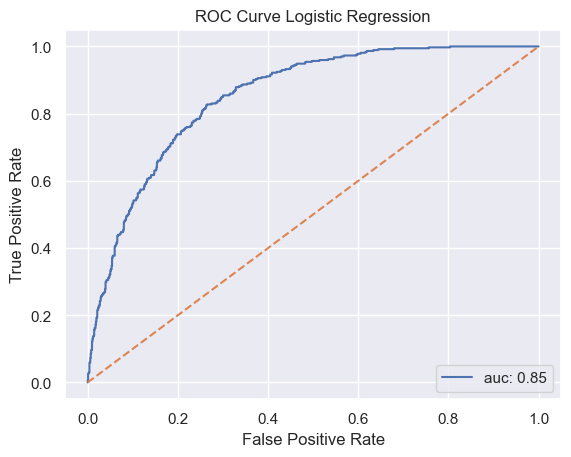

In [140]:
from sklearn.metrics import roc_curve, roc_auc_score


roc_auc = roc_auc_score(y_test, gridcv_lr.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, gridcv_lr.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr,label=f'auc: {roc_auc.round(2)}')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression');

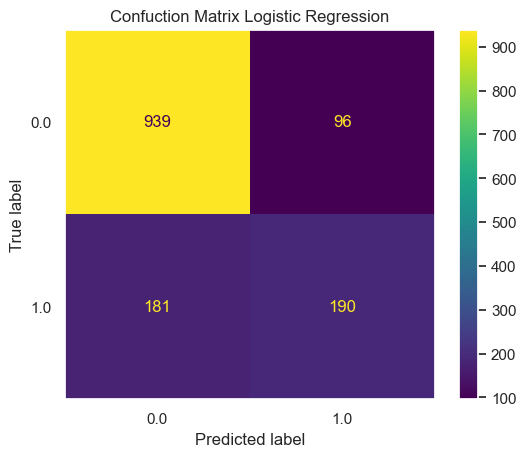

In [141]:
#Confusion Matrix
#metrics.confusion_matrix(y_test,y_pred_lr).round(2)

ConfusionMatrixDisplay.from_estimator(
    gridcv_lr, X_test, y_test)
plt.title('Confuction Matrix Logistic Regression')

plt.grid('')

## 3.2 Model 2: K Nearest Neighbors

In [24]:
from sklearn.neighbors import KNeighborsClassifier

#Instantiate KNN
knn = KNeighborsClassifier()

#Dictionary for hyperparameter tuning
neighbors_range = range(24,71)
knn_param_dict = {'n_neighbors':neighbors_range}

#Instantiate GridsearchCV
gridcv_knn = GridSearchCV(estimator=knn,cv=5,param_grid=knn_param_dict,verbose=0)

#Fit Gridsearch with training data
gridcv_knn.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(24, 71)})

In [25]:
# Best params
print(f'best params: {gridcv_knn.best_params_} \n')

#Best score
print(f'best score: {gridcv_knn.best_score_} \n')

#Mean test score
print(f'mean test score: \n {gridcv_knn.cv_results_['mean_test_score']}')

best params: {'n_neighbors': 24} 

best score: 0.7987220245156188 

mean test score: 
 [0.79872202 0.7980117  0.79605567 0.79712218 0.79783314 0.79658853
 0.79641076 0.79676584 0.79552123 0.79409964 0.79676694 0.79409964
 0.79569949 0.79676631 0.79818885 0.79676694 0.79623314 0.79552234
 0.79694535 0.7951671  0.79676742 0.79552313 0.7965898  0.7949898
 0.79587932 0.79338948 0.79498996 0.79481265 0.79445662 0.7953452
 0.79427758 0.7939225  0.79498885 0.79498901 0.79481076 0.79552266
 0.79623361 0.79569964 0.79569949 0.79641091 0.79712218 0.79641107
 0.79694409 0.79765583 0.79658837 0.7974779  0.79658837]


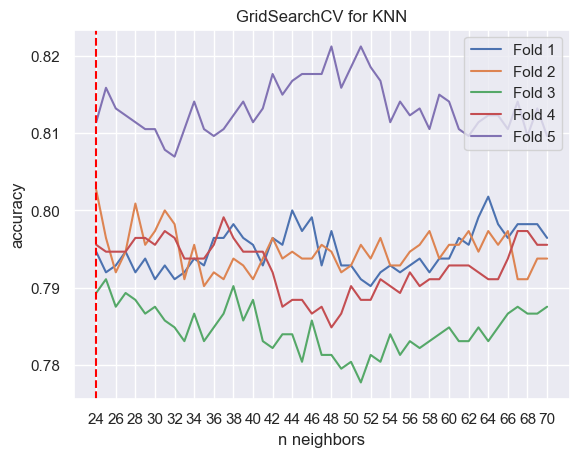

In [144]:
sns.lineplot(x=neighbors_range, y=gridcv_knn.cv_results_['split0_test_score'], label='Fold 1')
sns.lineplot(x=neighbors_range, y=gridcv_knn.cv_results_['split1_test_score'], label='Fold 2')
sns.lineplot(x=neighbors_range, y=gridcv_knn.cv_results_['split2_test_score'], label='Fold 3')
sns.lineplot(x=neighbors_range, y=gridcv_knn.cv_results_['split3_test_score'], label='Fold 4')
sns.lineplot(x=neighbors_range, y=gridcv_knn.cv_results_['split4_test_score'], label='Fold 5')
plt.xlabel('n neighbors')
plt.title('GridSearchCV for KNN')
plt.ylabel('accuracy')
plt.xticks(np.arange(24,71,2))
plt.axvline(gridcv_knn.best_params_['n_neighbors'],linestyle='--',color='red')
#plt.text(58,0.815,'best param',color='red');

In [26]:
#Predict y with test data
y_pred_knn = gridcv_knn.predict(X_test)

#Create empty dict
metrics_knn = {}

#Metrics to dict
metrics_knn['Accuracy'] = metrics.accuracy_score(y_test,y_pred_knn)
metrics_knn['Recall'] =metrics.recall_score(y_test,y_pred_knn)
metrics_knn['Precision'] =metrics.precision_score(y_test,y_pred_knn)
metrics_knn['F1'] = metrics.f1_score(y_test,y_pred_knn)

metrics_knn

{'Accuracy': 0.7802275960170697,
 'Recall': 0.4474393530997305,
 'Precision': 0.6148148148148148,
 'F1': 0.5179407176287052}

In [20]:
roc_auc = roc_auc_score(y_test, gridcv_knn.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, gridcv_knn.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr,label=f'auc: {roc_auc.round(2)}')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve KNN');

NameError: name 'roc_auc_score' is not defined

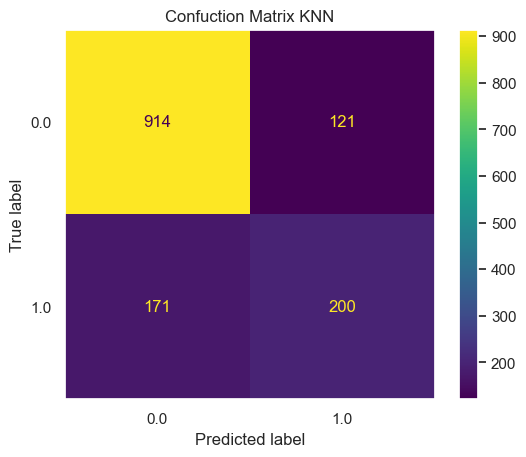

In [99]:
#Confusion Matrix
#metrics.confusion_matrix(y_test,y_pred_lr).round(2)

ConfusionMatrixDisplay.from_estimator(
    gridcv_knn, X_test, y_test)
plt.title('Confuction Matrix KNN')

plt.grid('')

## 3.3 Model 3: Support Vector Machines

In [100]:
from sklearn.svm import SVC

#Instantiate Support Vector Classifier
svm = SVC()

#Dictionary for hyperparameter tuning
svm_param_dict = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale', 'auto']}

#Instantiate GridsearchCV
gridcv_svm = GridSearchCV(estimator=svm,cv=5,param_grid=svm_param_dict,verbose=0)

#Fit Gridsearch with training data
gridcv_svm.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 1, 'scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']})

In [101]:
# Best params
print(f'best params: {gridcv_svm.best_params_} \n')

#Best score
print(f'best score: {gridcv_svm.best_score_} \n')

#Mean test score
print(f'mean test score: \n {gridcv_svm.cv_results_['mean_test_score']}')

best params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'} 

best score: 0.8026345591142745 

mean test score: 
 [0.80263456 0.79498648 0.78947489 0.80263456 0.75568968 0.73595382
 0.80263456 0.79463092 0.79249806 0.80263456 0.79729854 0.73595302
 0.8015671  0.80156694 0.79872234 0.8015671  0.78911839 0.71835097
 0.8015671  0.80014456 0.79978885 0.8015671  0.80067679 0.75942317
 0.80192297 0.78787616 0.78218537 0.80192297 0.77969395 0.70590368
 0.80192297 0.78520838 0.77489395 0.80192297 0.80067805 0.79338648]


In [102]:
#Predict y with test data
y_pred_svm = gridcv_svm.predict(X_test)

#Create empty dict
metrics_svm = {}

#Metrics to dict
metrics_svm['Accuracy'] = metrics.accuracy_score(y_test,y_pred_svm)
metrics_svm['Recall'] =metrics.recall_score(y_test,y_pred_svm)
metrics_svm['Precision'] =metrics.precision_score(y_test,y_pred_svm)
metrics_svm['F1'] = metrics.f1_score(y_test,y_pred_svm)

metrics_svm

{'Accuracy': 0.8008534850640113,
 'Recall': 0.48247978436657685,
 'Precision': 0.6704119850187266,
 'F1': 0.5611285266457681}

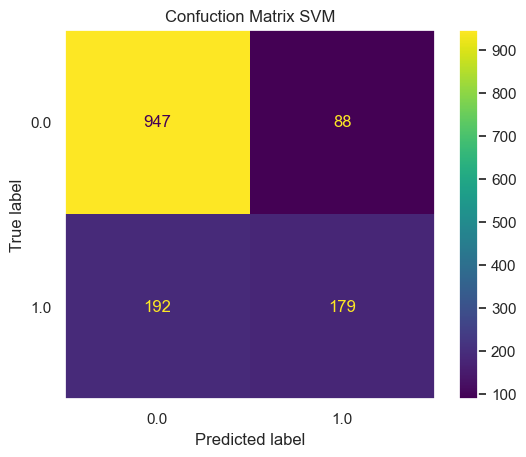

In [103]:
#Confusion Matrix
#metrics.confusion_matrix(y_test,y_pred_lr).round(2)

ConfusionMatrixDisplay.from_estimator(
    gridcv_svm, X_test, y_test)
plt.title('Confuction Matrix SVM')
plt.grid('')

## 3.4 Model 4: Ensemble - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Instantiate Support Vector Classifier
rf = RandomForestClassifier()

#Dictionary for hyperparameter tuning
rf_param_dict = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale', 'auto']}

#Instantiate GridsearchCV
gridcv_rf = GridSearchCV(estimator=rf,cv=5,param_grid=rf_param_dict,verbose=0)

#Fit Gridsearch with training data
gridcv_rf.fit(X_train,y_train)

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


param_rf = {'max_features':range(1,30)}
rf = RandomForestClassifier()
grid_rf = GridSearchCV(estimator=rf,param_grid=param_rf,cv=5,scoring='accuracy')

In [35]:
grid_rf.fit(X_train,y_train)
y_pred_rf = grid_rf.predict(X_test)
grid_rf.score(X_test,y_test)

0.786628733997155

## 3.5 Model 5: Ensemble - Voting Classifier

In [104]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lr',LogisticRegression(random_state=123)),
        ('rf',RandomForestClassifier(random_state=123)),
        ('svc',SVC(random_state=123)),
        ('knn',KNeighborsClassifier())
    ]
)

voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=123)),
                             ('rf', RandomForestClassifier(random_state=123)),
                             ('svc', SVC(random_state=123)),
                             ('knn', KNeighborsClassifier())])

In [105]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test,y_test))

lr = 0.8044096728307255
rf = 0.7837837837837838
svc = 0.798719772403983
knn = 0.7660028449502134


In [106]:
#[clf.predict(X_test[1:]) for clf in voting_clf.estimators_]

#Predict y with test data
voting_clf.predict(X_test[:1])

array([0.])

In [107]:
voting_clf.score(X_test,y_test)

0.7951635846372689

In [108]:
voting_clf.voting = 'soft'
voting_clf.named_estimators['svc'].probability = True
voting_clf.fit(X_train,y_train)
voting_clf.score(X_test,y_test)

0.7901849217638691

# 4 Evaluation

        Accuracy    Recall  Precision        F1
LogReg  0.805121  0.514825   0.670175  0.582317
KNN     0.792319  0.539084   0.623053  0.578035
SVM     0.800853  0.482480   0.670412  0.561129


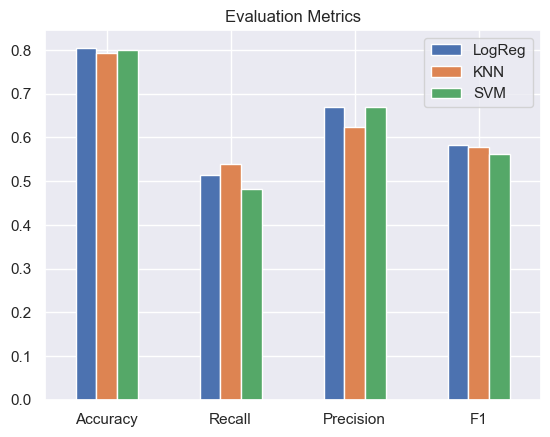

In [109]:
evaluation_matrix = pd.DataFrame({'LogReg':metrics_lr,'KNN':metrics_knn,'SVM':metrics_svm})
evaluation_matrix.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Evaluation Metrics');

print(evaluation_matrix.T)